<a href="https://colab.research.google.com/github/fmuranda/pythia-foundations/blob/main/core/xarray/dask-arrays-xarray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dask Arrays with Xarray

<img src="https://github.com/fmuranda/pythia-foundations/blob/main/core/xarray/images/dask_horizontal.svg?raw=1" align="left" width="30%">


The scientific Python package known as Dask [@https://doi.org/10.25080/Majora-7b98e3ed-013] provides Dask Arrays: parallel, larger-than-memory, n-dimensional arrays that make use of blocked algorithms. They are analogous to Numpy arrays, but are distributed. These terms are defined below:

*  **Parallel** code uses many or all of the cores on the computer running the code.
*  **Larger-than-memory** refers to algorithms that break up data arrays into small pieces, operate on these pieces in an optimized fashion, and stream data from a storage device. This allows a user or programmer to work with datasets of a size larger than the available memory.
*  A **blocked algorithm** speeds up large computations by converting them into a series of smaller computations.

In this tutorial, we cover the use of Xarray to wrap Dask arrays. By using Dask arrays instead of Numpy arrays in Xarray data objects, it becomes possible to execute analysis code in parallel with much less code and effort.


## Learning Objectives

- Learn the distinction between *eager* and *lazy* execution, and performing both types of execution with Xarray
- Understand key features of Dask Arrays
- Learn to perform operations with Dask Arrays in similar ways to performing operations with NumPy arrays
- Understand the use of Xarray `DataArrays` and `Datasets` as "Dask collections", and the use of top-level Dask functions such as `dask.visualize()` on such collections
- Understand the ability to use Dask transparently in all built-in Xarray operations

## Prerequisites


| Concepts | Importance | Notes |
| --- | --- | --- |
| [Introduction to NumPy](../numpy/numpy-basics) | Necessary | Familiarity with Data Arrays; {cite:t}`hoyer2017xarray` |
| [Introduction to Xarray](xarray-intro) | Necessary | Familiarity with Xarray Data Structures |


- **Time to learn**: *30-40 minutes*


## Imports

For this tutorial, as we are working with Dask, there are a number of Dask packages that must be imported. Also, this is technically an Xarray tutorial, so Xarray and NumPy must also be imported. Finally, the Pythia datasets package is imported, allowing access to the Project Pythia example data library.

In [ ]:
import dask
import dask.array as da
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar
from dask.utils import format_bytes
from pythia_datasets import DATASETS

## Blocked algorithms

As described above, the definition of "blocked algorithm" is an algorithm that replaces a large operation with many small operations. In the case of datasets, this means that a blocked algorithm separates a dataset into chunks, and performs an operation on each.

As an example of how blocked algorithms work, consider a dataset containing a billion numbers, and assume that the sum of the numbers is needed. Using a non-blocked algorithm, all of the numbers are added in one operation, which is extremely inefficient. However, by using a blocked algorithm, the dataset is broken into chunks. (For the purposes of this example, assume that 1,000 chunks are created, with 1,000,000 numbers each.) The sum of the numbers in each chunk is taken, most likely in parallel, and then each of those sums are summed to obtain the final result.

By using blocked algorithms, we achieve the result, in this case one sum of one billion numbers, through the results of many smaller operations, in this case one thousand sums of one million numbers each. (Also note that each of the one thousand sums must then be summed, making the total number of sums 1,001.) This allows for a much greater degree of parallelism, potentially speeding up the code execution dramatically.

### `dask.array` contains these algorithms

The main object type used in Dask is `dask.array`, which implements a subset of the `ndarray` (NumPy array) interface. However, unlike `ndarray`, `dask.array` uses blocked algorithms, which break up the array into smaller arrays, as described above. This allows for the execution of computations on arrays larger than memory, by using parallelism to divide the computation among multiple cores. Dask manages and coordinates blocked algorithms for any given computation by using Dask graphs, which lay out in detail the steps Dask takes to solve a problem. In addition, `dask.array` objects, known as Dask Arrays, are **lazy**; in other words, any computation performed on them is delayed until a specific method is called.

### Create a `dask.array` object

As stated earlier, Dask Arrays are loosely based on NumPy arrays. In the next set of examples, we illustrate the main differences between Dask Arrays and NumPy arrays. In order to illustrate the differences, we must have both a Dask Array object and a NumPy array object. Therefore, this first example creates a 3-D NumPy array of random data:

In [ ]:
shape = (600, 200, 200)
arr = np.random.random(shape)
arr

array([[[8.62018289e-01, 5.66850268e-01, 7.79790085e-01, ...,
         4.21285225e-01, 2.12232022e-01, 5.93622355e-01],
        [7.24784274e-01, 5.01878686e-01, 1.85883394e-01, ...,
         1.40656723e-01, 5.43711253e-01, 7.24028174e-01],
        [7.59854500e-01, 1.76984611e-01, 3.84891520e-01, ...,
         3.54327956e-01, 9.71970346e-01, 3.98555717e-02],
        ...,
        [2.32357426e-01, 7.11959883e-01, 9.06685511e-01, ...,
         2.72831446e-01, 4.24104160e-01, 3.30458633e-01],
        [6.66590773e-01, 6.53127092e-01, 9.86113702e-01, ...,
         7.93583135e-01, 1.51768165e-01, 3.49865023e-01],
        [6.84853648e-01, 3.34054170e-01, 3.24158247e-01, ...,
         8.44866464e-01, 2.65397659e-01, 3.38987566e-01]],

       [[1.64271680e-01, 2.00041312e-01, 9.64573620e-02, ...,
         7.20643973e-01, 9.71659413e-01, 9.49055944e-02],
        [8.07381683e-02, 1.34410707e-01, 1.63303565e-01, ...,
         5.62793927e-01, 7.44234874e-01, 4.23781533e-01],
        [1.46326265e-01, 

In [ ]:
format_bytes(arr.nbytes)

'183.11 MiB'

As shown above, this NumPy array contains about 183 MB of data.

As stated above, we must also create a Dask Array. This next example creates a Dask Array with the same dimension sizes as the existing NumPy array:

In [ ]:
darr = da.random.random(shape, chunks=(300, 100, 200))

By specifying values to the `chunks` keyword argument, we can specify the array pieces that Dask's blocked algorithms break the array into; in this case, we specify `(300, 100, 200)`.

```{admonition} Specifying Chunks
:class: tip

In this tutorial, we specify Dask Array chunks in a block shape. However, there are many additional ways to specify chunks; see [this documentation](https://docs.dask.org/en/latest/array-chunks.html) for more details.

If you are viewing this page as a Jupyter Notebook, the next Jupyter cell will produce a rich information graphic giving in-depth details about the array and each individual chunk.

In [ ]:
darr

dask.array<random_sample, shape=(600, 200, 200), dtype=float64, chunksize=(300, 100, 200), chunktype=numpy.ndarray>

The above graphic contains a symbolic representation of the array, including `shape`, `dtype`, and `chunksize`. (Your view may be different, depending on how you are accessing this page.) Notice that there is no data shown for this array; this is because Dask Arrays are lazy, as described above. Before we call a compute method for this array, we first illustrate the structure of a Dask graph. In this example, we show the Dask graph by calling `.visualize()` on the array:

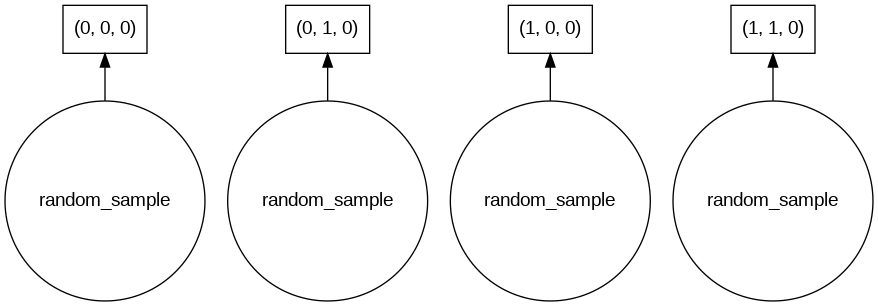

In [ ]:
darr.visualize()

As shown in the above Dask graph, our array has four chunks, each one created by a call to NumPy's "random" method (`np.random.random`). These chunks are concatenated into a single array after the calculation is performed.

### Manipulate a `dask.array` object as you would a numpy array


We can perform computations on the Dask Array created above in a similar fashion to NumPy arrays. These computations include arithmetic, slicing, and reductions, among others.

Although the code for performing these computations is similar between NumPy arrays and Dask Arrays, the process by which they are performed is quite different. For example, it is possible to call `sum()` on both a NumPy array and a Dask Array; however, these two `sum()` calls are definitely not the same, as shown below.

#### What's the difference?

When `sum()` is called on a Dask Array, the computation is not performed; instead, an expression of the computation is built. The `sum()` computation, as well as any other computation methods called on the same Dask Array, are not performed until a specific method (known as a compute method) is called on the array. (This is known as **lazy execution**.) On the other hand, calling `sum()` on a NumPy array performs the calculation immediately; this is known as **eager execution**.

#### Why the difference?

As described earlier, a Dask Array is divided into chunks. Any computations run on the Dask Array run on each chunk individually. If the result of the computation is obtained before the computation runs through all of the chunks, Dask can stop the computation to save CPU time and memory resources.

This example illustrates calling `sum()` on a Dask Array; it also includes a demonstration of lazy execution, as well as another Dask graph display:

In [ ]:
total = darr.sum()
total

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

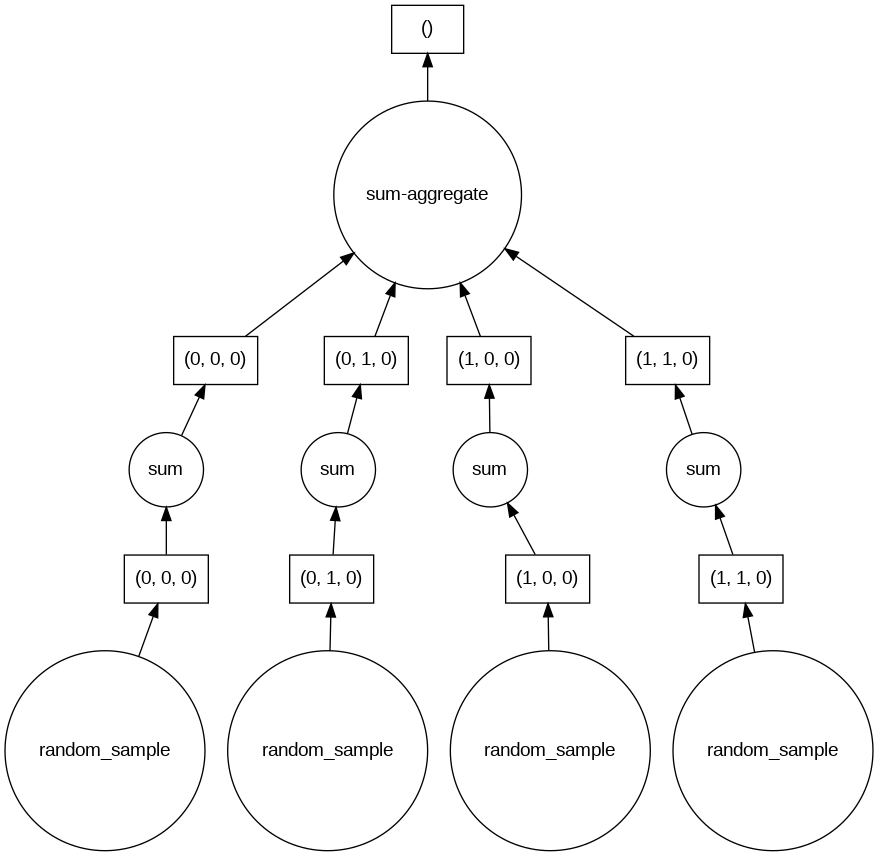

In [ ]:
total.visualize()

#### Compute the result

As described above, Dask Array objects make use of lazy execution. Therefore, operations performed on a Dask Array wait to execute until a compute method is called. As more operations are queued in this way, the Dask Array's Dask graph increases in complexity, reflecting the steps Dask will take to perform all of the queued operations.

In this example, we call a compute method, simply called `.compute()`, to run on the Dask Array all of the stored computations:

In [ ]:
%%time
total.compute()

CPU times: user 413 ms, sys: 72.6 ms, total: 486 ms
Wall time: 277 ms


np.float64(11998891.318464687)

### Exercise with `dask.arrays`

In this section of the page, the examples are hands-on exercises pertaining to Dask Arrays. If these exercises are not interesting to you, this section can be used strictly as examples regardless of how the page is viewed. However, if you wish to participate in the exercises, make sure that you are viewing this page as a Jupyter Notebook.

For the first exercise, modify the chunk size or shape of the Dask Array created earlier. Call `.sum()` on the modified Dask Array, and visualize the Dask graph to view the changes.

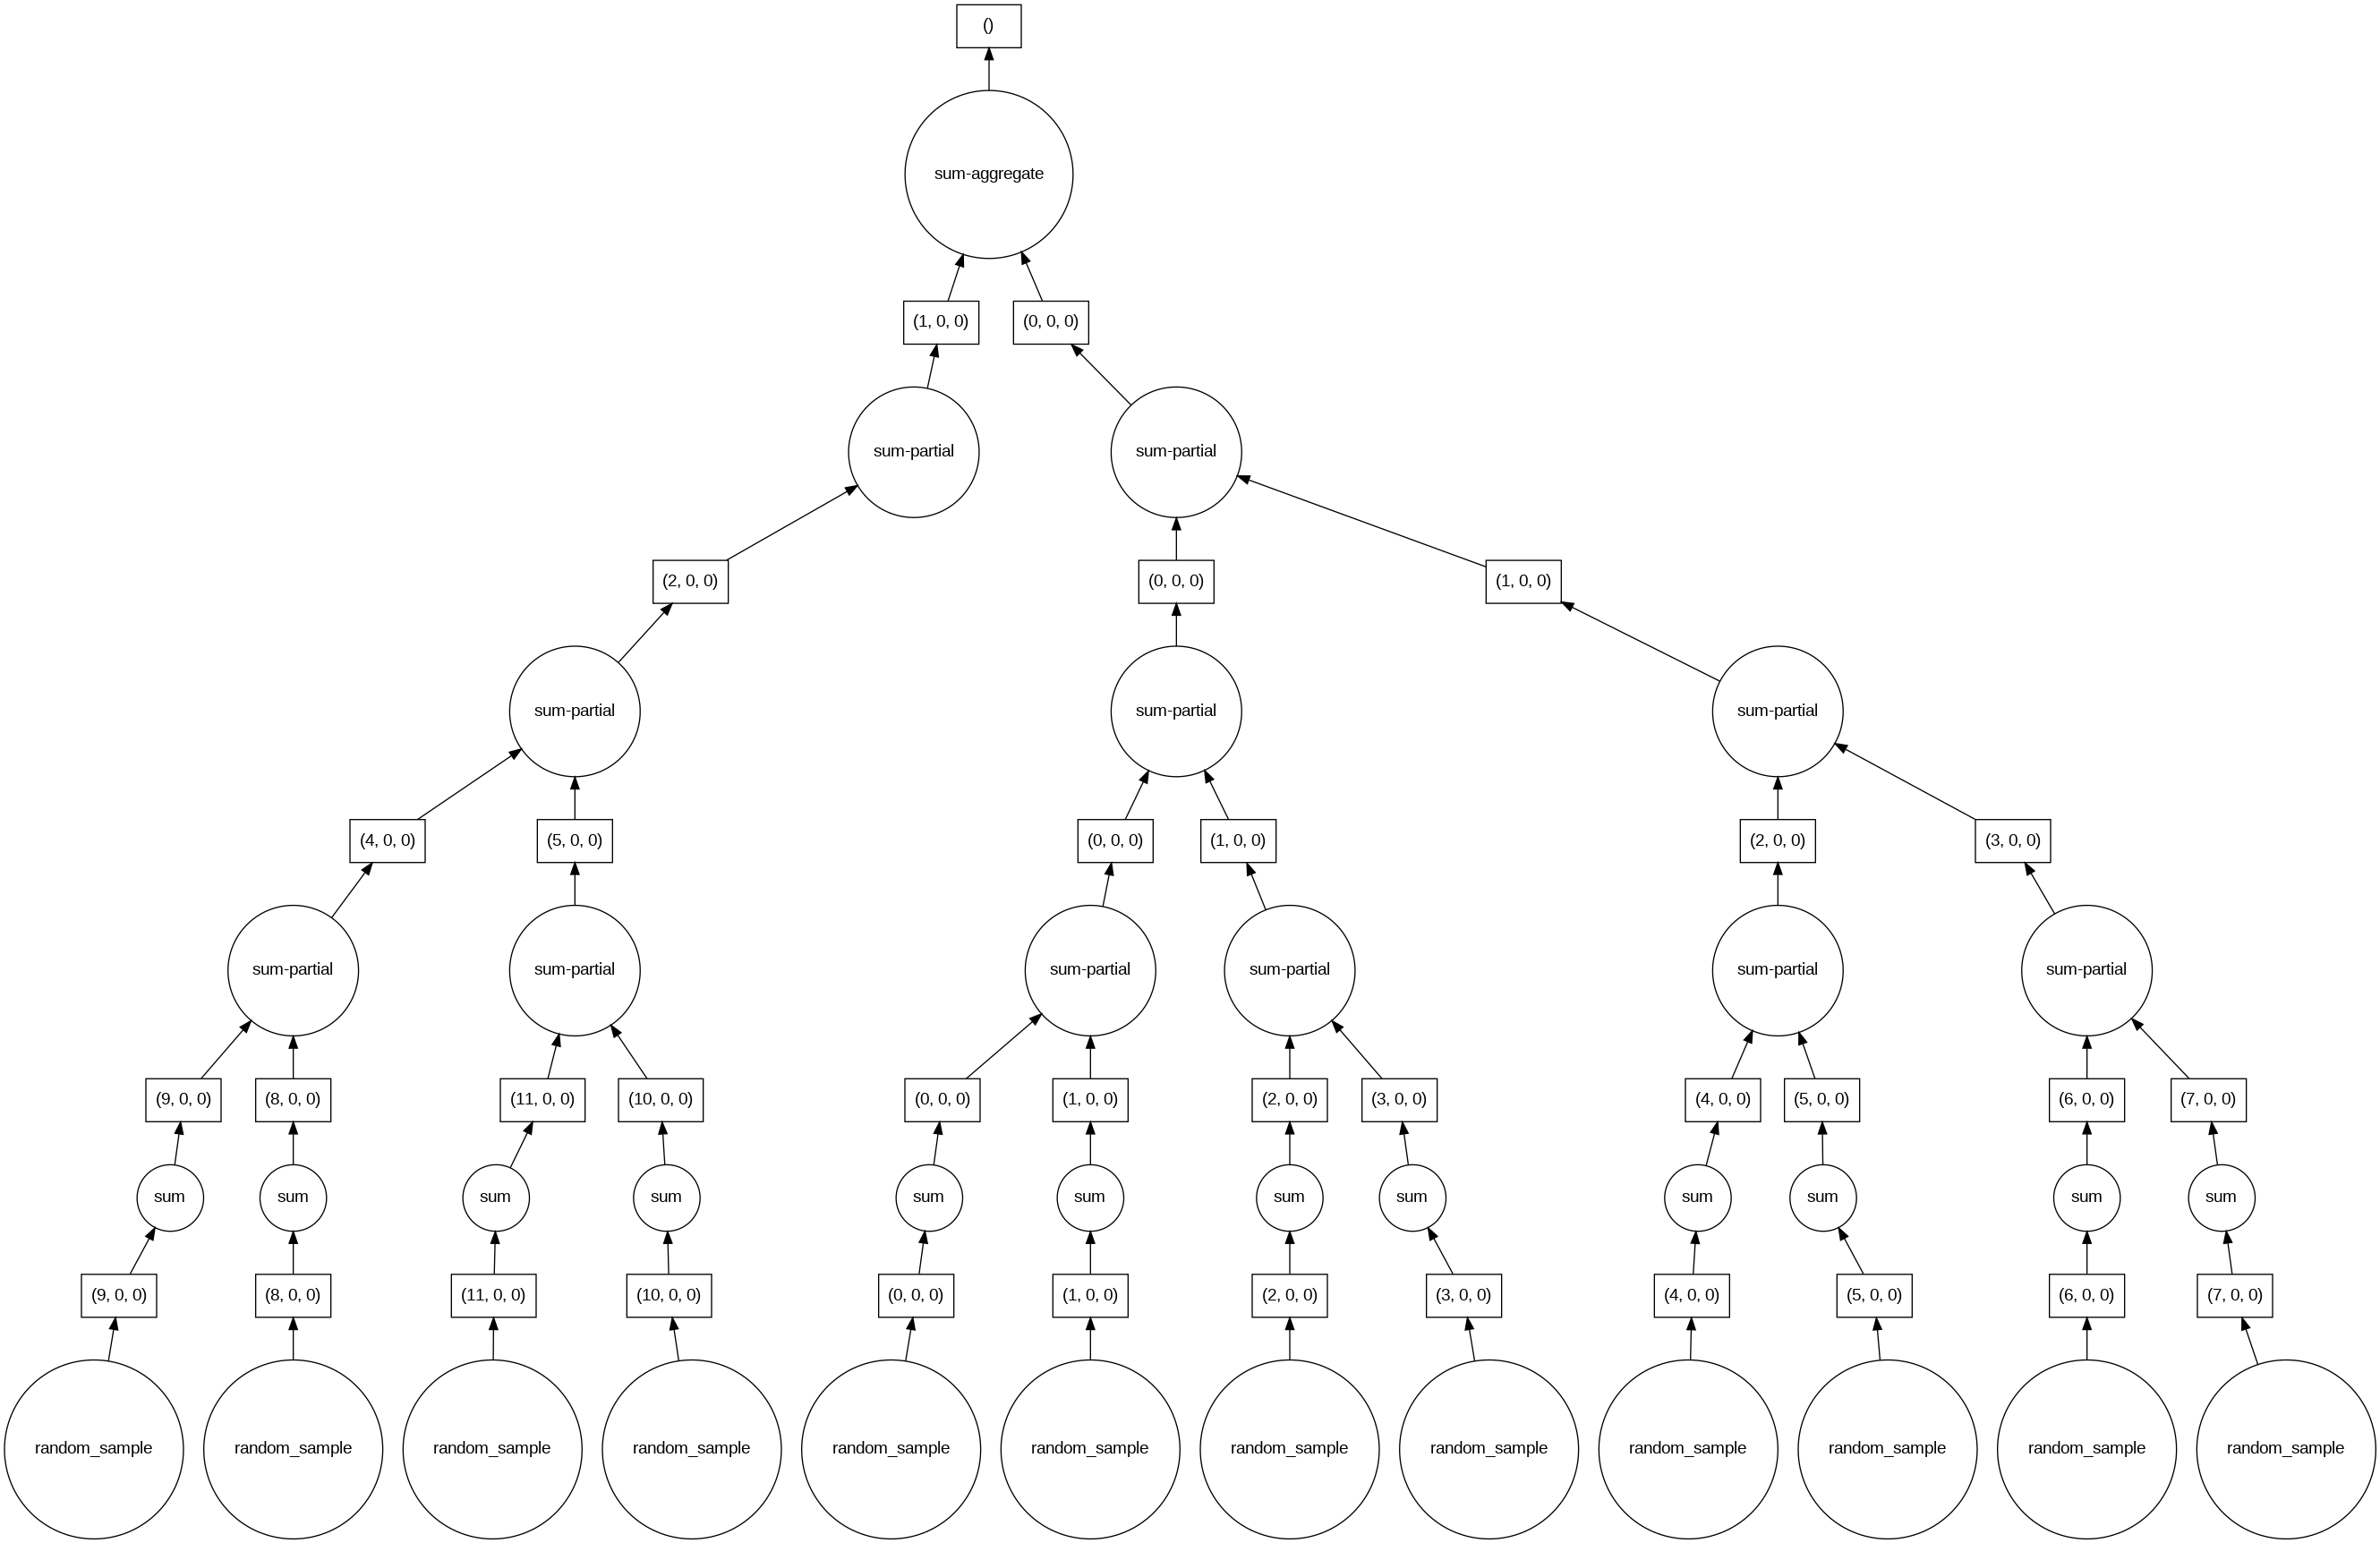

In [ ]:
da.random.random(shape, chunks=(50, 200, 400)).sum().visualize()

As is obvious from the above exercise, Dask quickly and easily determines a strategy for performing the operations, in this case a sum. This illustrates the appeal of Dask: automatic algorithm generation that scales from simple arithmetic problems to highly complex scientific equations with large datasets and multiple operations.

In this next set of examples, we demonstrate that increasing the complexity of the operations performed also increases the complexity of the Dask graph.

In this example, we use randomly selected functions, arguments and Python slices to create a complex set of operations. We then visualize the Dask graph to illustrate the increased complexity:

In [ ]:
z = darr.dot(darr.T).mean(axis=0)[::2, :].std(axis=1)
z

dask.array<_sqrt, shape=(100, 600), dtype=float64, chunksize=(50, 300), chunktype=numpy.ndarray>

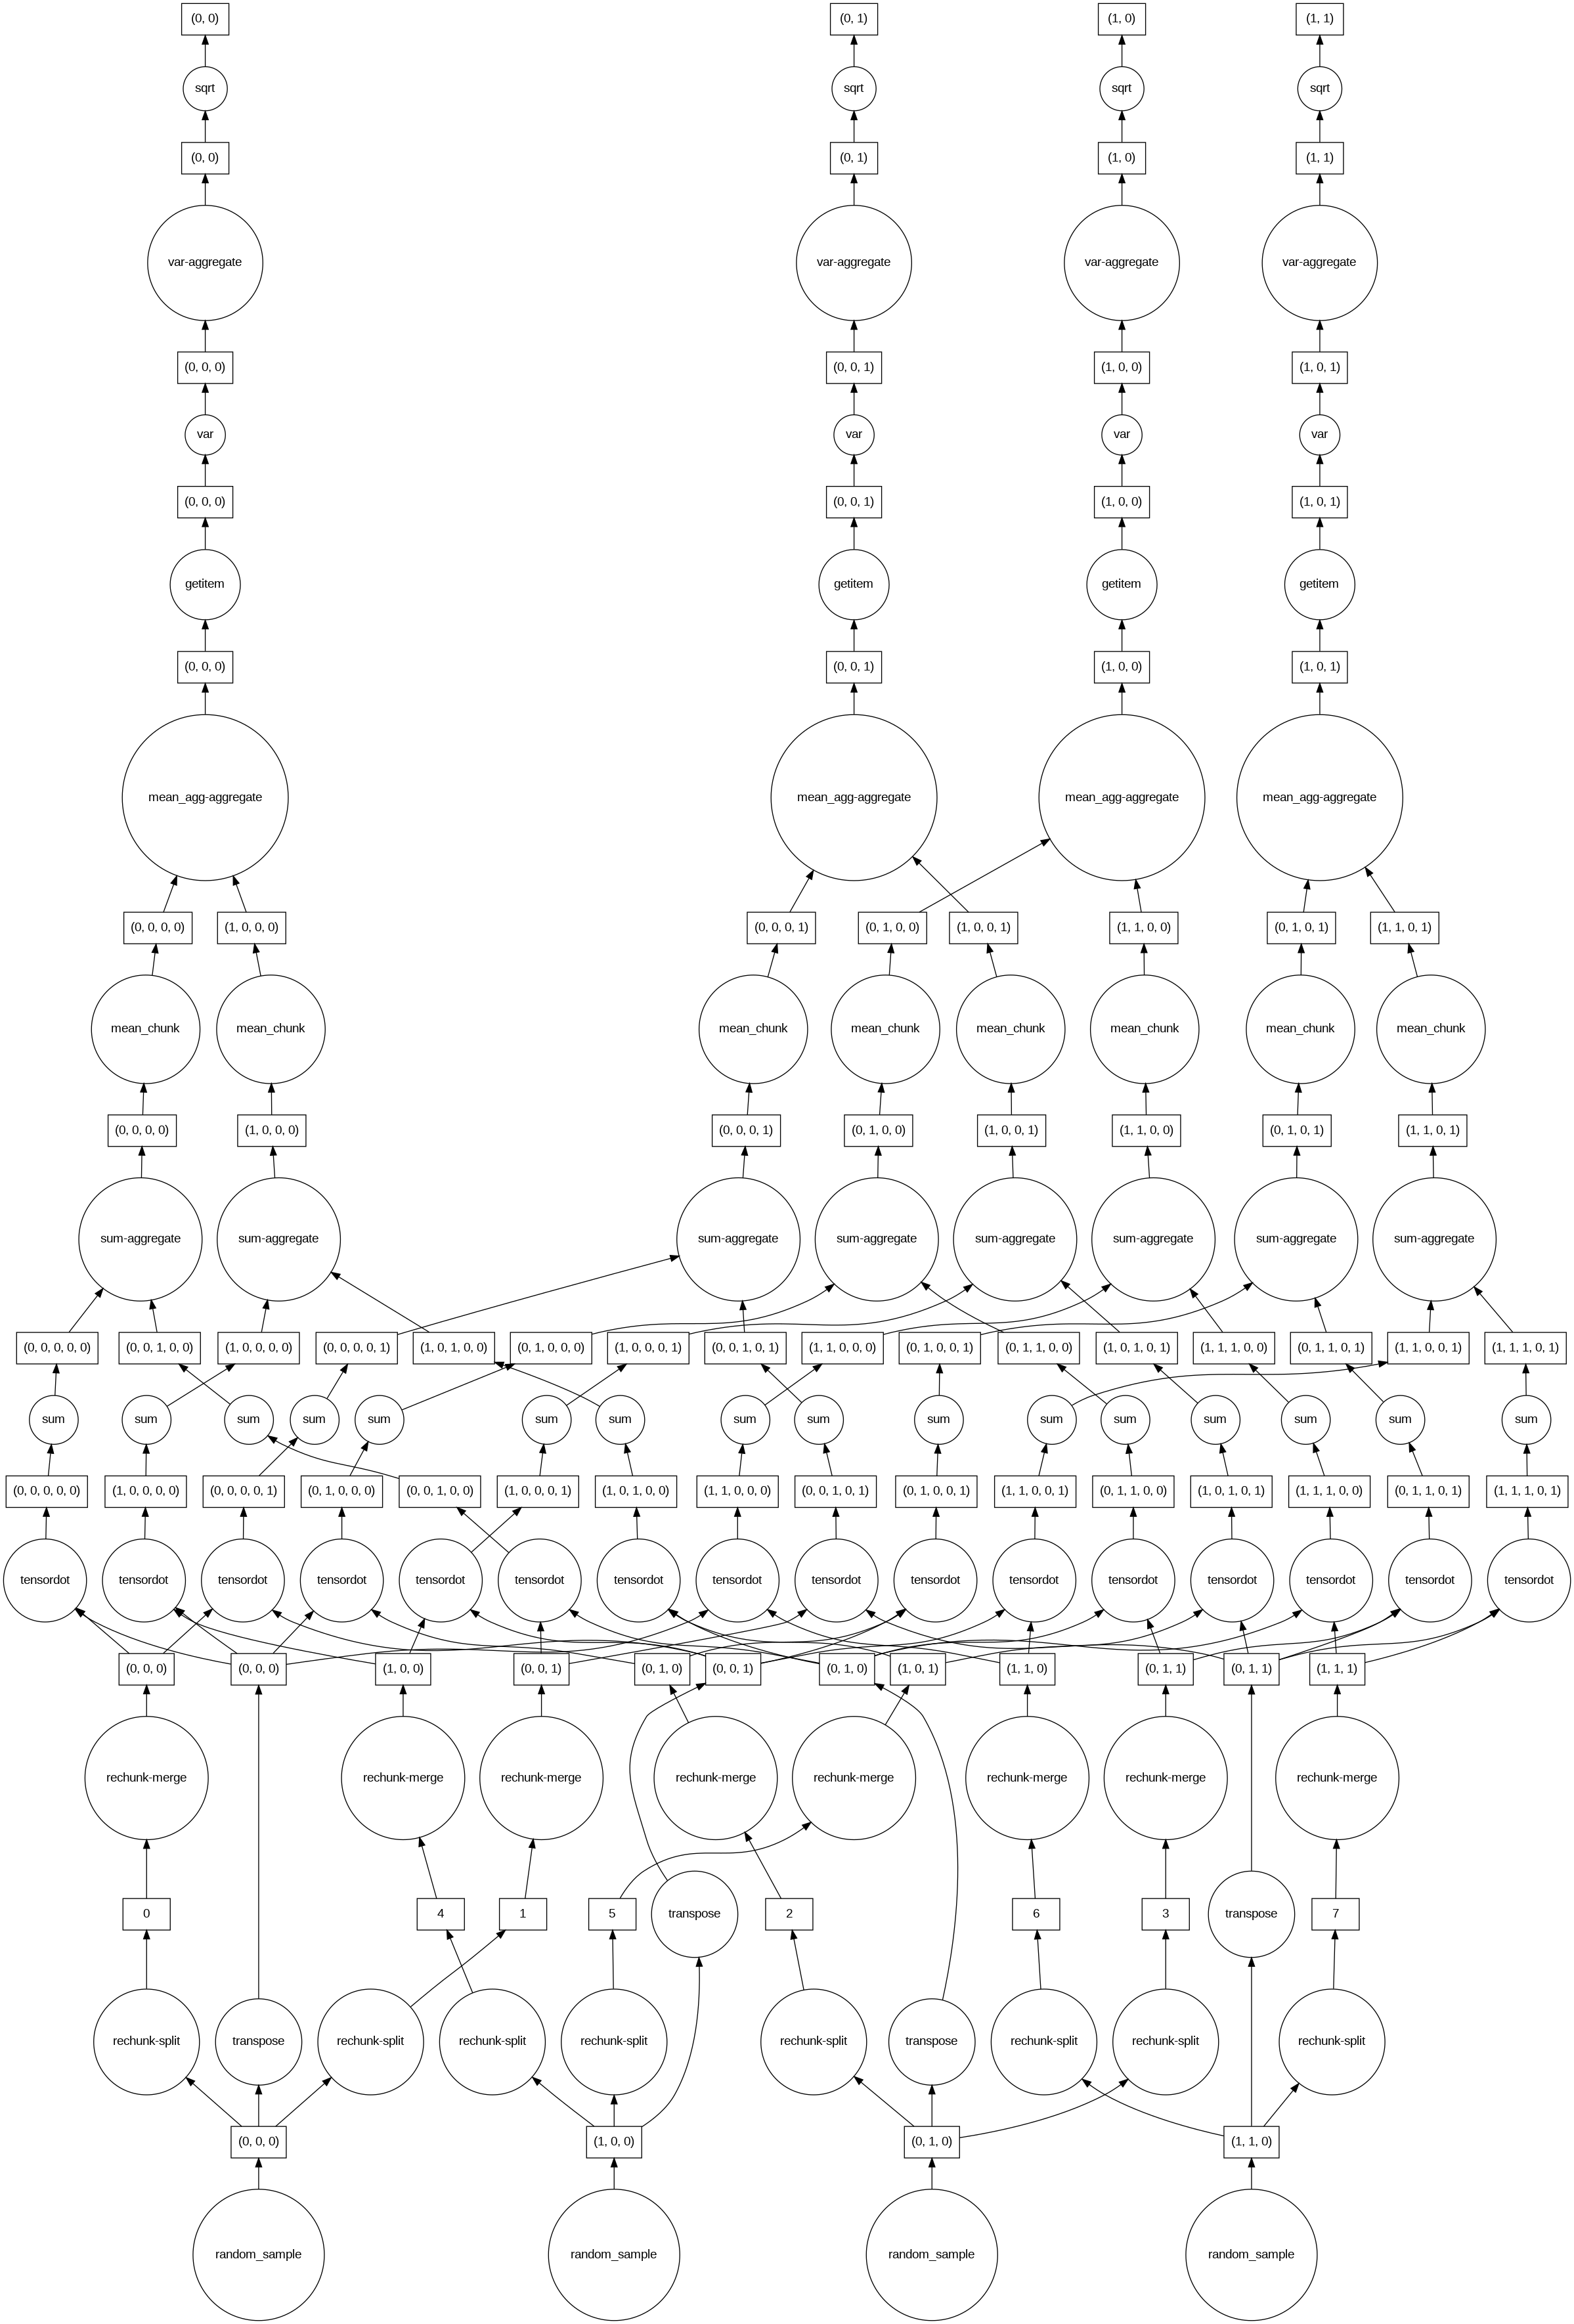

In [ ]:
z.visualize()

### Testing a bigger calculation

While the earlier examples in this tutorial described well the basics of Dask, the size of the data in those examples, about 180 MB, is far too small for an actual use of Dask.

In this example, we create a much larger array, more indicative of data actually used in Dask:

In [ ]:
darr = da.random.random((4000, 100, 4000), chunks=(1000, 100, 500)).astype('float32')
darr

dask.array<astype, shape=(4000, 100, 4000), dtype=float32, chunksize=(1000, 100, 500), chunktype=numpy.ndarray>

The dataset created in the previous example is much larger, approximately 6 GB. Depending on how many programs are running on your computer, this may be greater than the amount of free RAM on your computer. However, as Dask is larger-than-memory, the amount of free RAM does not impede Dask's ability to work on this dataset.

In this example, we again perform randomly selected operations, but this time on the much larger dataset. We also visualize the Dask graph, and then run the compute method. However, as computing complex functions on large datasets is inherently time-consuming, we show a progress bar to track the progress of the computation.

In [ ]:
z = (darr + darr.T)[::2, :].mean(axis=2)

In [ ]:
z.visualize()

In [ ]:
with ProgressBar():
    computed_ds = z.compute()

[########################################] | 100% Completed | 42.93 s


## Dask Arrays with Xarray

While directly interacting with Dask Arrays can be useful on occasion, more often than not Dask Arrays are interacted with through [Xarray](http://xarray.pydata.org/en/stable/
). Since Xarray wraps NumPy arrays, and Dask Arrays contain most of the functionality of NumPy arrays, Xarray can also wrap Dask Arrays, allowing anyone with knowledge of Xarray to easily start using the Dask interface.

### Reading data with `Dask` and `Xarray`

As demonstrated in previous examples, a Dask Array consists of many smaller arrays, called chunks:

In [ ]:
darr

dask.array<astype, shape=(4000, 100, 4000), dtype=float32, chunksize=(1000, 100, 500), chunktype=numpy.ndarray>

As shown in the following example, to read data into Xarray as Dask Arrays, simply specify the `chunks` keyword argument when calling the `open_dataset()` function:

In [ ]:
!pip install cftime
import xarray as xr
ds = xr.open_dataset(DATASETS.fetch('CESM2_sst_data.nc'), chunks={}, use_cftime=True)
ds.tos

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00


/tmp/ipython-input-4065955742.py:3: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds = xr.open_dataset(DATASETS.fetch('CESM2_sst_data.nc'), chunks={}, use_cftime=True)
/usr/local/lib/python3.12/dist-packages/xarray/conventions.py:204: SerializationWarning: variable 'tos' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


<xarray.DataArray 'tos' (time: 180, lat: 180, lon: 360)> Size: 47MB
dask.array<open_dataset-tos, shape=(180, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1kB 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

While it is a valid operation to pass an empty list to the `chunks` keyword argument, this technique does not specify how to chunk the data, and therefore the resulting Dask Array contains only one chunk.

Correct usage of the `chunks` keyword argument specifies how many values in each dimension are contained in a single chunk. In this example, specifying the chunks keyword argument as `chunks={'time':90}` indicates to Xarray and Dask that 90 time slices are allocated to each chunk on the temporal axis.

Since this dataset contains 180 total time slices, the data variable `tos` (holding the sea surface temperature data) is now split into two chunks in the temporal dimension.

In [ ]:
ds = xr.open_dataset(
    DATASETS.fetch('CESM2_sst_data.nc'),
    engine="h5netcdf",
    chunks={"time": 90, "lat": 180, "lon": 360},
)
ds.tos

/usr/local/lib/python3.12/dist-packages/xarray/conventions.py:204: SerializationWarning: variable 'tos' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


<xarray.DataArray 'tos' (time: 180, lat: 180, lon: 360)> Size: 47MB
dask.array<open_dataset-tos, shape=(180, 180, 360), dtype=float32, chunksize=(90, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1kB 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

It is fairly straightforward to retrieve a list of the chunks and their sizes for each dimension; simply call the `.chunks` method on an Xarray `DataArray`. In this example, we show that the `tos` `DataArray` now contains two chunks on the `time` dimension, with each chunk containing 90 time slices.

In [ ]:
ds.tos.chunks

((90, 90), (180,), (360,))

### Xarray data structures are first-class dask collections

If an Xarray `Dataset` or `DataArray` object uses a Dask Array, rather than a NumPy array, it counts as a first-class Dask collection. This means that you can pass such an object to `dask.visualize()` and `dask.compute()`, in the same way as an individual Dask Array.

In this example, we call `dask.visualize` on our Xarray `DataArray`, displaying a Dask graph for the `DataArray` object:

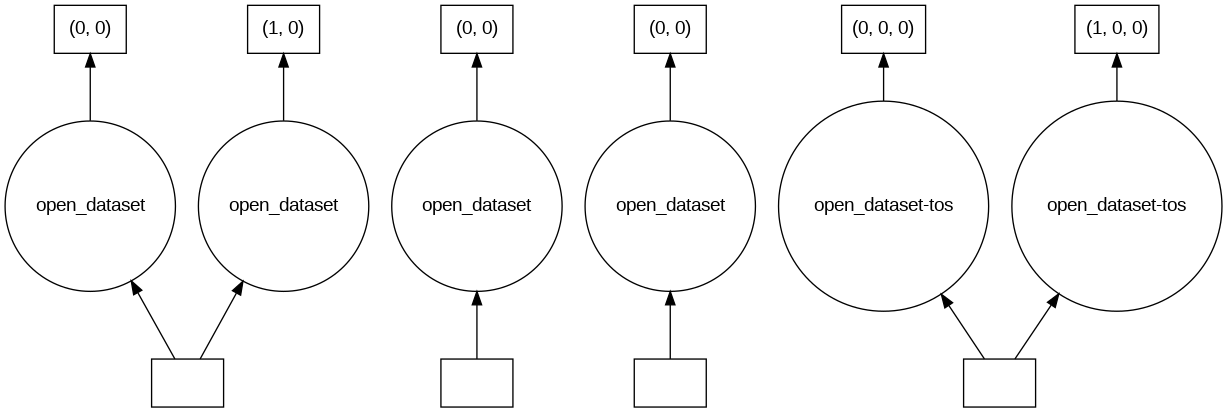

In [ ]:
dask.visualize(ds)

### Parallel and lazy computation using `dask.array` with Xarray


As described above, Xarray `Datasets` and `DataArrays` containing Dask Arrays are first-class Dask collections. Therefore, computations performed on such objects are deferred until a compute method is called. (This is the definition of lazy computation.)

In [ ]:
z = ds.tos.mean(['lat', 'lon']).dot(ds.tos.T)
z

<xarray.DataArray 'tos' (lon: 360, lat: 180)> Size: 259kB
dask.array<sum-aggregate, shape=(360, 180), dtype=float32, chunksize=(360, 180), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

As shown in the above example, the result of the applied operations is an Xarray `DataArray` that contains a Dask Array, an identical object type to the object that the operations were performed on. This is true for any operations that can be applied to Xarray `DataArrays`, including subsetting operations; this next example illustrates this:

In [ ]:
z.isel(lat=0)

<xarray.DataArray 'tos' (lon: 360)> Size: 1kB
dask.array<getitem, shape=(360,), dtype=float32, chunksize=(360,), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lat      float64 8B -89.5
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

Because the data subset created above is also a first-class Dask collection, we can view its Dask graph using the `dask.visualize()` function, as shown in this example:

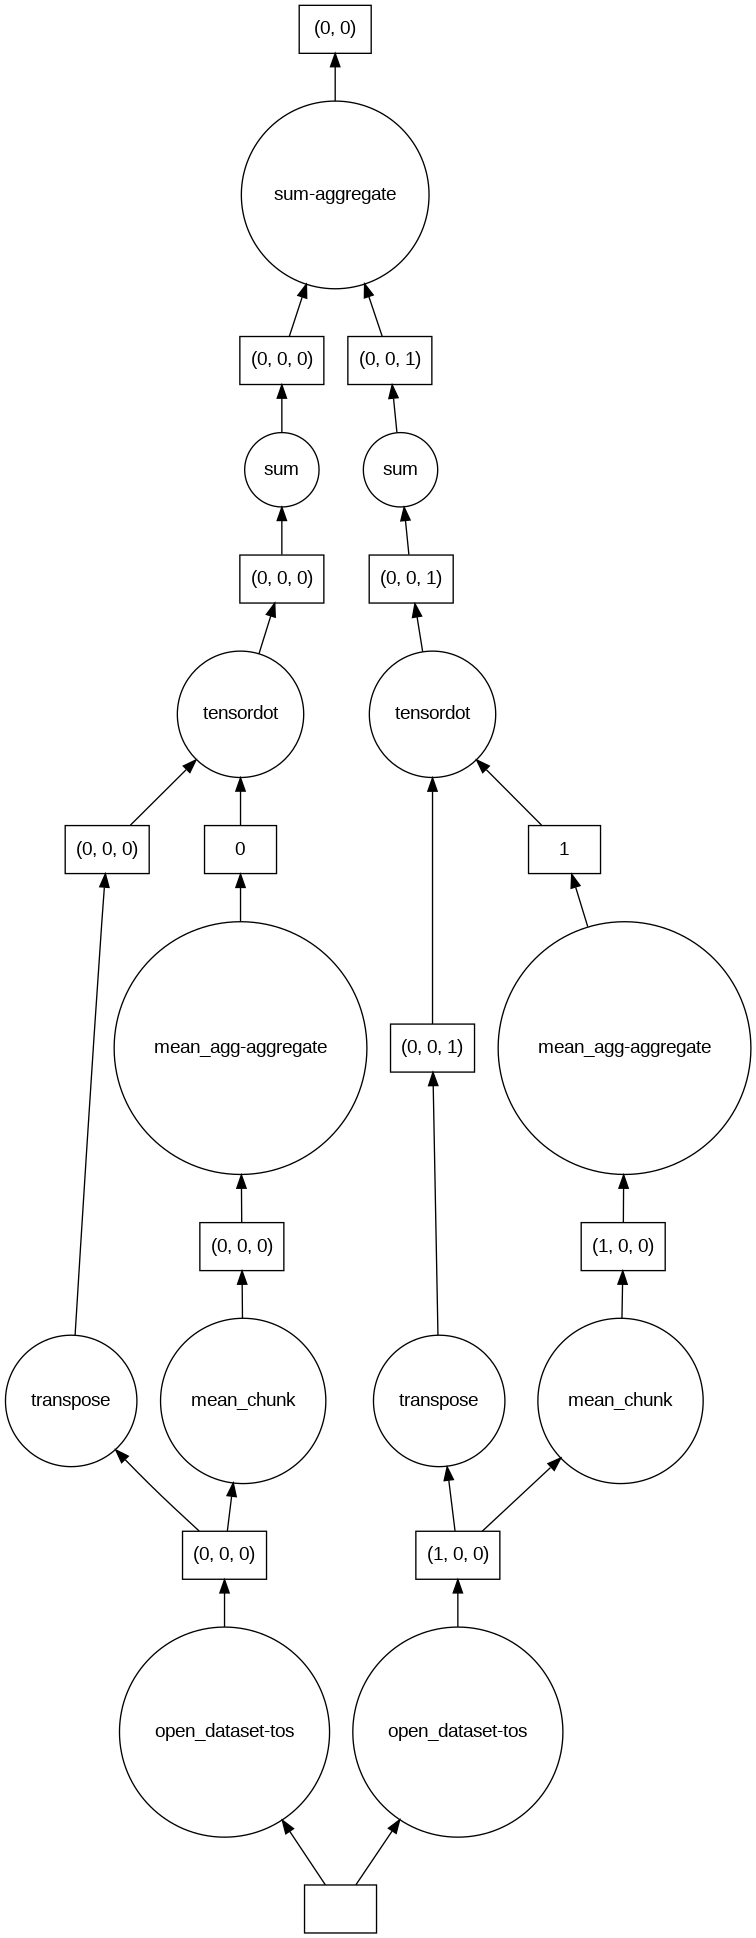

In [ ]:
dask.visualize(z)

Since this object is a first-class Dask collection, the computations performed on it have been deferred. To run these computations, we must call a compute method, in this case `.compute()`. This example also uses a progress bar to track the computation progress.

In [ ]:
with ProgressBar():
    computed_ds = z.compute()

[########################################] | 100% Completed | 521.27 ms


---

## Summary

This tutorial covered the use of Xarray to access Dask Arrays, and the use of the `chunks` keyword argument to open datasets with Dask data instead of NumPy data. Another important concept introduced in this tutorial is the usage of Xarray `Datasets` and `DataArrays` as Dask collections, allowing Xarray objects to be manipulated in a similar manner to Dask Arrays. Finally, the concepts of larger-than-memory datasets, lazy computation, and parallel computation, and how they relate to Xarray and Dask, were covered.

### Dask Shortcomings

Although Dask Arrays and NumPy arrays are generally interchangeable, NumPy offers some functionality that is lacking in Dask Arrays. The usage of Dask Array comes with the following relevant issues:

1.  Operations where the resulting shape depends on the array values can produce erratic behavior, or fail altogether, when used on a Dask Array. If the operation succeeds, the resulting Dask Array will have unknown chunk sizes, which can cause other sections of code to fail.
2.  Operations that are by nature difficult to parallelize or less useful on very large datasets, such as `sort`, are not included in the Dask Array interface. Some of these operations have supported versions that are inherently more intuitive to parallelize, such as [`topk`](https://pytorch.org/docs/stable/generated/torch.topk.html).
3.  Development of new Dask functionality is only initiated when such functionality is required; therefore, some lesser-used NumPy functions, such as `np.sometrue`, are not yet implemented in Dask. However, many of these functions can be added as community contributions, or have already been added in this manner.

## Learn More

For more in-depth information on Dask Arrays, visit the [official documentation page](https://docs.dask.org/en/latest/array.html). In addition, [this screencast](https://youtu.be/9h_61hXCDuI) reinforces the concepts covered in this tutorial. (If you are viewing this page as a Jupyter Notebook, the screencast will appear below as an embedded YouTube video.)


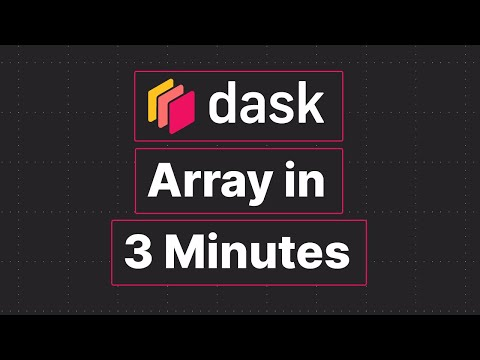

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo(id="9h_61hXCDuI", width=600, height=300)

## Additional Resources

* To find specific reference information about Dask and Xarray, see the official documentation pages listed below:
    *  [Dask Docs](https://dask.org/)
    *  [Dask Examples](https://examples.dask.org/)
    *  [Dask Code](https://github.com/dask/dask/)
    *  [Dask Blog](https://blog.dask.org/)
    
    *  [Xarray Docs](https://xarray.pydata.org/)
  
*  If you require assistance with a specific issue involving Xarray or Dask, the following resources may be of use:
    *   Dask tag on StackOverflow, for usage questions
    *   [github discussions: dask](https://github.com/dask/dask/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: dask](https://github.com/dask/dask/issues/new) for bug reports and feature requests
     *   [github discussions: xarray](https://github.com/pydata/xarray/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: xarray](https://github.com/pydata/xarray/issues/new) for bug reports and feature requests
    
* Certain sections of this tutorial are adapted from the following existing tutorials:
  * [Dask Array Tutorial](https://tutorial.dask.org/02_array.html)
  * [Parallel Computing with Xarray and Dask](https://tutorial.xarray.dev/intermediate/xarray_and_dask.html)